## 

## Load packages

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate: Same as specificity
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Load data

In [3]:
# Set up dictionary for CSV files
csv_files = dict()

# Load files into dictionary
filenames = os.listdir('./data_csv')
for file in filenames:
    filename, file_extension = os.path.splitext(f'./data_csv/{file}')
    # Remove path from filenmaes and load data
    if file_extension == '.csv':
        filename_short = filename.split('/')[-1]
        csv_files[filename_short] = pd.read_csv(f'./data_csv/{file}')

# Load meta data and transform
metadata = pd.read_csv('./data_csv/metadata.csv', index_col='parameter')
csv_index = list(metadata)

In [4]:
csv_files[csv_index[0]]

,seconds,FHR,UC
0,0,146.75,20.5
1,1,151.00,19.0
2,2,151.00,18.5
3,3,151.75,19.0
4,4,147.00,24.5
...,...,...,...
21595,21595,0.00,0.0
21596,21596,0.00,0.0
21597,21597,0.00,0.0
21598,21598,0.00,0.0


In [5]:
def remove_records_without_last_x_min_y_percent_complete_fhr(x, y):
    selected_records = dict()
    for index in csv_index:
        df = csv_files[index]
        fhr = df['FHR'].values[-x * 60:]
        complete = fhr > 0
        if complete.mean() >= y/100:
            selected_records[index] = df
    return selected_records    

In [6]:
records_with_required_completion = (
    remove_records_without_last_x_min_y_percent_complete_fhr(45, 50))

len(records_with_required_completion.keys())

402

In [7]:
def remove_when_zero_fhr(data_dict):
    zeros_removed = dict()
    for index in data_dict.keys():
        df = data_dict[index]
        fhr = df['FHR']
        mask = fhr > 0
        zeros_removed[index] = df[mask]
    return zeros_removed
        
    

In [8]:
cleaned_data = remove_when_zero_fhr(records_with_required_completion)

In [9]:
def truncate(data_dict, required_length):
    truncated_data = dict()
    for index in data_dict.keys():
        df = data_dict[index]
        if len(df) >= required_length * 60:
            truncated_data[index] = df.tail(required_length * 60)
    return truncated_data
    

In [10]:
cleaned_data = truncate(cleaned_data, 30)

In [13]:
def stack_data_in_numpy(data_dict):
    order = []
    stacked_data = []
    for index in data_dict.keys():
        order.append(index)
        df = data_dict[index]
        stacked_data.append(df[['FHR', 'UC']].values)
    stacked_data = np.stack(stacked_data)
    return stacked_data, order

In [14]:
cleaned_data_np, cleaned_data_index = stack_data_in_numpy(cleaned_data)

In [15]:
cleaned_data_np[0,:,:]

array([[140.75,   1.  ],
       [139.5 ,   1.  ],
       [141.5 ,   1.  ],
       ...,
       [ 62.25,   6.  ],
       [ 69.25,   6.  ],
       [ 69.25,   6.  ]])

In [16]:
cleaned_data_np.shape

(402, 1800, 2)

In [20]:
metadata = metadata[cleaned_data_index].T

In [21]:
metadata.shape

(402, 35)

In [22]:
metadata

parameter,pH,BDecf,pCO2,BE,Apgar1,Apgar5,NICU days,Seizures,HIE,Intubation,...,Induced,I.stage,NoProgress,CK/KP,II.stage,Deliv. type,dbID,Rec. type,Pos. II.st.,Sig2Birth
1040,7.17,2.22,9.4,-5.4,8.0,8.0,0.0,0.0,0.0,0.0,...,1.0,273.0,0.0,0.0,15.0,1.0,1004453.0,2.0,14400.0,0.0
1286,7.14,9.06,7.3,-10.9,10.0,10.0,0.0,0.0,0.0,0.0,...,0.0,325.0,0.0,0.0,20.0,1.0,1064096.0,1.0,14400.0,0.0
1264,7.35,3.33,5.2,-3.9,9.0,9.0,0.0,0.0,0.0,0.0,...,1.0,130.0,0.0,0.0,5.0,1.0,1059216.0,2.0,14400.0,0.0
1301,7.37,0.16,5.7,-0.8,9.0,9.0,0.0,0.0,0.0,0.0,...,1.0,198.0,0.0,0.0,5.0,1.0,1065261.0,1.0,14400.0,0.0
1124,7.26,1.31,7.5,-3.3,8.0,9.0,0.0,0.0,0.0,0.0,...,0.0,267.0,0.0,0.0,30.0,1.0,1028309.0,1.0,14400.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,7.21,1.28,8.7,-3.8,9.0,10.0,0.0,0.0,0.0,0.0,...,0.0,68.0,0.0,0.0,10.0,1.0,1046278.0,1.0,14400.0,0.0
1238,7.23,5.27,6.8,-7.0,8.0,8.0,0.0,0.0,0.0,0.0,...,1.0,276.0,0.0,0.0,10.0,1.0,1055054.0,1.0,14400.0,0.0
1027,7.33,3.08,5.6,-4.3,9.0,9.0,0.0,0.0,0.0,0.0,...,1.0,105.0,0.0,0.0,15.0,1.0,995007.0,12.0,14400.0,0.0
1471,7.18,2.04,9.2,-4.5,9.0,9.0,0.0,0.0,0.0,0.0,...,0.0,360.0,0.0,0.0,15.0,1.0,1106454.0,1.0,14400.0,0.0


In [41]:
poor_outcome = (metadata['pH'] < 7.2) | (metadata['Apgar1'] < 7)
y = poor_outcome.values * 1

In [42]:
y

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,

In [46]:
X_fhr = cleaned_data_np[:,:,0]
X_uc = cleaned_data_np[:,:,1]

In [45]:
X_fhr

array([[140.75, 139.5 , 141.5 , ...,  62.25,  69.25,  69.25],
       [108.75, 108.  , 108.  , ..., 146.5 , 146.25, 147.  ],
       [142.75, 142.75, 142.75, ...,  82.25,  82.25,  82.25],
       ...,
       [143.5 , 145.  , 145.75, ...,  96.25,  97.  ,  97.  ],
       [131.  , 130.75, 130.75, ..., 146.25, 144.  , 144.  ],
       [113.75, 113.75, 118.5 , ..., 148.75, 150.25, 152.5 ]])

In [47]:
X_uc

array([[ 1. ,  1. ,  1. , ...,  6. ,  6. ,  6. ],
       [46. , 46. , 46. , ...,  1.5,  1.5,  1.5],
       [23. , 23. , 24. , ...,  0. ,  0. ,  0. ],
       ...,
       [ 3. ,  3. ,  3. , ...,  3. ,  3. ,  3. ],
       [46.5, 45.5, 45.5, ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]])

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_fhr, y, test_size = 0.25, random_state=42, stratify=y)

In [67]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

In [68]:
# Scale X data
X_train_sc, X_test_sc = scale_data(X_train, X_test)

X_train_sc = X_train_sc.reshape((X_train_sc.shape[0], X_train_sc.shape[1], 1))
X_test_sc = X_test_sc.reshape((X_test_sc.shape[0], X_test_sc.shape[1], 1))

n_classes = len(np.unique(y_train))

In [69]:
from tensorflow import keras
from tensorflow.keras import layers

In [70]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    #conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    #conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    #conv3 = keras.layers.MaxPooling1D(pool_size=2)(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(n_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=X_train_sc.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [71]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train_sc,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
8/8 [==============================] - 1s 52ms/step - loss: 0.6888 - sparse_categorical_accuracy: 0.5750 - val_loss: 0.6828 - val_sparse_categorical_accuracy: 0.6557 - lr: 0.0010
Epoch 2/500
8/8 [==============================] - 0s 28ms/step - loss: 0.6165 - sparse_categorical_accuracy: 0.6417 - val_loss: 0.6631 - val_sparse_categorical_accuracy: 0.6557 - lr: 0.0010
Epoch 3/500
8/8 [==============================] - 0s 29ms/step - loss: 0.6231 - sparse_categorical_accuracy: 0.6792 - val_loss: 0.6566 - val_sparse_categorical_accuracy: 0.6557 - lr: 0.0010
Epoch 4/500
8/8 [==============================] - 0s 29ms/step - loss: 0.6105 - sparse_categorical_accuracy: 0.6917 - val_loss: 0.6509 - val_sparse_categorical_accuracy: 0.6557 - lr: 0.0010
Epoch 5/500
8/8 [==============================] - 0s 30ms/step - loss: 0.5995 - sparse_categorical_accuracy: 0.7000 - val_loss: 0.6460 - val_sparse_categorical_accuracy: 0.6557 - lr: 0.0010
Epoch 6/500
8/8 [============================

In [72]:
y_pred = model.predict(X_test_sc)[:,1]

from sklearn.metrics import auc
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print (f'AUC {roc_auc:0.4f}')

4/4 [==============================] - 0s 7ms/step
AUC 0.6124


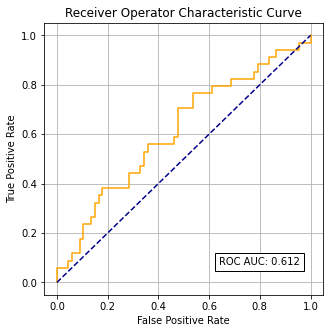

In [73]:
fig = plt.figure(figsize=(5,5))

# Plot ROC
ax1 = fig.add_subplot(111)
ax1.plot(fpr, tpr, color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'ROC AUC: {roc_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)
plt.show()

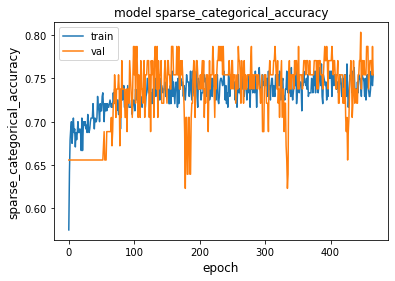

In [74]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()